# Improving baseline model
> With an aim to build a SOTA model on flowers-102 dataset by employing Fastai techniques.

- toc: true
- branch: master
- badges: true
- comments: true
- author: Harish Vadlamani
- image: images/ttl_small.png
- categories: [Image Classification]

---
## Introduction 

In my previous blog post ["Building an image classifier using Fastai
"](https://harish3110.github.io/through-tinted-lenses/computer%20vision/image%20classification/2021/09/29/Building-an-image-classifier-using-Fastai.html), I introduced the Fastai V2 library by building a baseline flower classifier model on the flowers-102 dataset. 

The baseline model created achieved an accuracy of about 96.2% on the validation set. The main aim of this post is to improve on my current baseline by employing some of the strategies taught in the Fastai course in order to reach the SOTA for the flowers-102 dataset which is an accuracy of 99.7%. 

---

Let's first import the Fastai library:

In [3]:
from fastai.vision.all import *
%matplotlib inline

In [2]:
#hide
# %%javascript
# $('.nbp-app-bar').toggle()

---

## Re-loading the baseline model

In the previous post, I saved the model created in order to re-load it again when needed. A saved model basically saves the weights and bias matrices for each of the layers of the architecture trained for the specific task. When the model is saved, behind the scenes Fastai uses saves the models `state_dict` and stores it in a pickle file.

To reload the model we could simply do: ```learn.load('flowers-baseline')```

But hold on, it isn't quite that simple. 

To load all those weight matrices properly we need to clearly define the architecture of the model as it was defined while training the model. So we follow the same steps as we did last time to create the `DataBlock`, then creating the `dataloaders` from it and finally specify the architecture we used by creating the `Learner`.

In [5]:
path = untar_data(URLs.FLOWERS)
df = pd.read_csv('data/df.csv', index_col=0)

In [6]:
files = get_image_files(path/'jpg')

In [7]:
def get_x(r): return path/r['name']
def get_y(r): return r['class']

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=RandomSplitter(seed=42),
                   get_x= get_x,
                   get_y= get_y, 
                   item_tfms = Resize(224))
dls = dblock.dataloaders(df) 

In [8]:
learn = vision_learner(dls, resnet34, metrics=accuracy)

In [7]:
learn.load('flowers-baseline')

To view the weight and bias matrices of our model we can check its `state_dict` as follows:

```learn.model.state_dict()```

> ***Note:*** When we do a `model.save` behind the scenes Fastai is calling upon PyTorch to save this `state_dict`. Something along the lines of this:
```torch.save(learn.model.state_dict(), 'checkpoint.pkl')```

>This is what is also happening when we use a pretrained model. We are basically taking the `state_dict` of a model trained for hours together and using it for our purposes!

Now that our pre-trained model is loaded, lets check where we stand by interpreting and validating our model on the validation set. 

---

### Model interpretation

In [8]:
interp = ClassificationInterpretation.from_learner(learn)

One way to see how good your model is doing by using the `confusion matrix` which basically plots the matrix of correct predictions of the each class as compared to others. This means we can see the classes that were mistaken as the other by looking at a single class. You can do so in Fastai by running the following code:

```interp.plot_confusion_matrix(figsize=(12,12), dpi=60)```

But in this case reading a confusion matrix would actually be pretty confusing since there are 102 different classes. So instead Fastai's `most_confused` will be used. This plots just the classes which were most frequently classified wrong which can be considered as a more refined and consise version of the confusion matrix.

So since all we want to know is which classes were moslty classified we can use Fastai's `most_confused` method as follows:

In [9]:
interp.most_confused(min_val=2)

[(' carnation', ' sweet william', 2),
 (' japanese anemone', ' windflower', 2),
 (' morning glory', ' thorn apple', 2),
 (' petunia', ' tree mallow', 2),
 (' sword lily', ' cyclamen ', 2),
 (' sword lily', ' desert-rose', 2),
 (' sword lily', ' rose', 2)]

---
### Model prediction

Let's see how our model fares on new images taken from Google. I'm using an image of a sunflower here:

<AxesSubplot:>

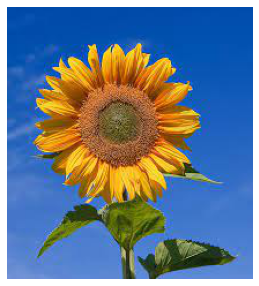

In [10]:
flower = PILImage.create('images/sunflower.jpg')
flower.show()

In [11]:
learn.predict(flower)[0]

' sunflower'

We can see that the baseline model correctly predicts the flower class.

In [12]:
preds,targs = learn.get_preds()

Let's use the `accuracy` method in Fastai to check the validation accuracy of the model:

In [13]:
accuracy(preds, targs)

TensorBase(0.9633)

This is same as using the `validate` on the learner:

In [14]:
learn.validate()

(#2) [0.1354469358921051,0.9633476138114929]

So that's our baseline model of an accuracy of 96.2%. Let's try to improve upon it!

---

## Presizing

In the previous post, I explain how the images passed to the GPU needs to have the same dimensions so that they can be collated into tensors and effectively transferred onto to GPU. Thus at the very least doing a ***Resize*** operation in the `item_tfms` when creating the `DataBlock` is mandatory. 

But if you think about it, simply resizing images is not a great idea. This might lead to producing improper cropped images, or images with empty areas or only parts of an image. 

Also, doing all these transforms on a GPU is an expensive process, so finding an effective way to get this done by composing the augmentations to reduce the number of transforms being done would also be quite helpful

So to get over these issues the Fastai library employs a method called `presizing`as follows:

1. We choose an appropriate large enough size based on our dataset to resize to such that there is enough room for further augmentations to be doe without any loss of data. 

2. All the necessary augmentations are composed and performed together on the GPU and finally resized to our desired size. 


> ***Note:*** In practice, the crop area chosen for the first step is at random for the training set and a center crop is done for the test images.

Let's check the size of a couple images in dataset to get an idea of what size to actually resize to in the 1st step:

In [18]:
print(PILImage.create(files[0]).shape)
print(PILImage.create(files[10]).shape)
print(PILImage.create(files[100]).shape)

(500, 667)
(500, 662)
(500, 702)


We see that the images are rectangle images with a fixed width of 500 and varying height. We can either work with rectangle images for our model but based on Jeremy's experimentation, in practice working with square images makes computation faster and produces almost similar results. 

So lets choose a size of 460*460 that's smaller than the original image and gives us enough wiggle room to work with for the augmentations. Let's see how that resize looks like:

> ***Note:*** By default, Fastai does a random crop when calling the resize function. 

<AxesSubplot:title={'center':'original image'}>

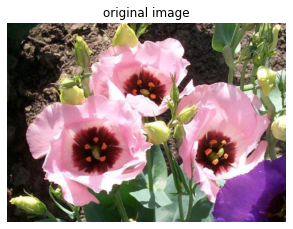

In [19]:
img = PILImage.create(files[100])
show_image(img, title='original image')

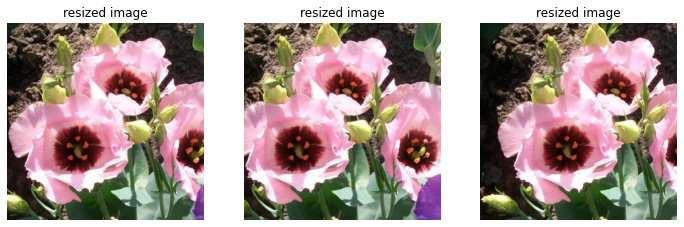

In [20]:
_,axs = plt.subplots(1,3,figsize=(12,4))

for ax in axs:
    rsz = Resize(460, method=ResizeMethod.Crop)
    show_image(rsz(img), title='resized image', ctx=ax);

We then use `aug_transforms` which is a Fastai utility function to perform a list of transforms efficiently on images as follows:

```batch_tfms=aug_transforms(size=224, min_scale=0.75)```

Here by choosing a `size` of '224' and `min_scale` != 1, We are telling Fastai to perform a random resized crop on the images to the final size of 224*224.  

> ***Note:*** A `RandomResizedCrop` by default does a random crop of images in the training set and does a center crop of images in the validation set. 

In [21]:
# Presizing
item_tfms=Resize(460),
batch_tfms=aug_transforms(size=224, min_scale=0.75)

def get_x(r): return path/r['name']
def get_y(r): return r['class']

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=RandomSplitter(seed=42),
                   get_x= get_x,
                   get_y= get_y, 
                   item_tfms = item_tfms,
                   batch_tfms = batch_tfms)
dls = dblock.dataloaders(df) 

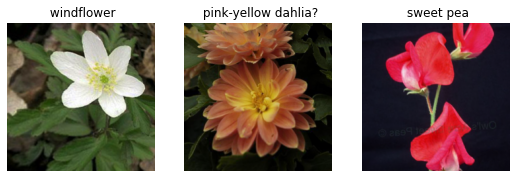

In [22]:
# Sanity check: Viewing a batch of images
dls.show_batch(nrows=1, ncols=3)

In [23]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.826566,0.664916,0.841784,00:28


epoch,train_loss,valid_loss,accuracy,time
0,0.695056,0.238678,0.935858,00:33
1,0.315113,0.140501,0.962126,00:33
2,0.160112,0.118961,0.967013,00:33


In [24]:
learn.save('flowers-presizing')

Path('models/flowers-presizing.pth')

We can see that `Presizing` improved the accuracy of the model by almost 1% (from 96% to 97%), we can also see that the validation loss is also reducing and so is the training loss. 

> In practice, Fastai's recommendation is to always use presizing as it siginficantly improves model performance as the images obtained by doing all the destructive augmentation steps in a composed and efficient manner leads to better quality images. Additionally, by composing these transforms together there is an additional advantage of the model training faster overall. 

---

## Learning rate finder

We know that choosing a good learning rate for the training process is vital. Till now we were using the default learning rate used in Fastai but let's dig deeper and choose a more suitable one for training the model more efficiently.

By default in Fastai the learning rate when using `cnn_learner` is set to 10e-3 i.e. 0.001 as shown below in its documentation. 

In [25]:
item_tfms=Resize(460),
batch_tfms=aug_transforms(size=224, min_scale=0.75)

def get_x(r): return path/r['name']
def get_y(r): return r['class']

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=RandomSplitter(seed=42),
                   get_x= get_x,
                   get_y= get_y, 
                   item_tfms = item_tfms,
                   batch_tfms = batch_tfms)
dls = dblock.dataloaders(df) 

Fastai employs the popular `learning rate finder` trick as created by Leslie Smith to find an optimum learning rate to train a neural network model. In short the learning rate finder is a plot of the loss of our model over an epoch by gradually increasing our learning rate from a low value at each mini-batch to a very high value until the loss blows off. Then a smooth version of this plot is used to determine the region where the 'best learning' takes place and accordingly an ideal learning rate is decided upon.

This is done in Fastai as follows:

In [28]:
learn = vision_learner(dls, resnet34, metrics=accuracy)

SuggestedLRs(valley=0.001737800776027143)

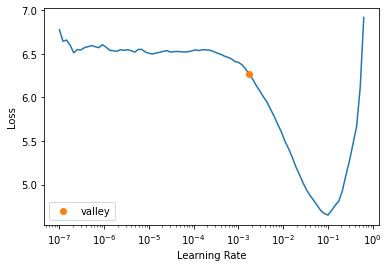

In [29]:
learn.lr_find()

From the above plot we can see that the plot has areas where loss is plateaud at first(i.e. no learning is taking place), then there is a gradual descent where the bulk of learning takes place and finally the loss shoots up and model goes out of wack!

We would like to choose a learning rate somewhere in the region where there's the gradual descent, not too low where the training process is waning but somewhere in the middle where the slope is high enough to induce a good learning for the model.

In this learning rate plot it appears that a learning rate around `3e-3` has a good learning slope and would be appropriate, so let's choose that.

In [30]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(3, base_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.435299,0.535012,0.849114,00:28


epoch,train_loss,valid_loss,accuracy,time
0,0.587888,0.231958,0.927917,00:33
1,0.288231,0.136378,0.963348,00:33
2,0.113643,0.098781,0.971900,00:33


***Note:*** : Everytime you change something in the model and need to retrain again, you will need to reset the learner. 

> To know more about finding a good learning rate, the thought process and code behind the learning rate finder in Fastai, please refer to Sylvain Gugger's wonderful post on ["How Do You Find A Good Learning Rate"](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html#how-do-you-find-a-good-learning-rate)

---

## 1 Cycle training

Another novel approach of training brought about easily using the Fastai library is Leslie Smith's 1cycle training.

In summary this method is executed in 2 phases:

1. `warm-up`: This is where during the training the learning rate is gradually increased from a the the 10th of the learning rate decided by using the `lr_finder` to the our chosen one, i.e `3e-3`.

2. `annealing`: This is where the learning rate is reduced to gradually again to a much lower point that the original in order to find the best minima to finally land on.

This method allows us train the major chunk of the model at higher learning rates using the learning rate restriction we had already calculated using the `lr_finder`. This, in practice has proven to show that models train much faster and also train better as they generalize better by missing dubious local minimas and thus finding smoother regions in the curve.

In [31]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.992500,0.445616,0.875382,00:28
1,0.654101,0.192593,0.943189,00:28
2,0.306958,0.171833,0.954184,00:28


In [32]:
learn.unfreeze()

We unfreeze the previous pretrained layers and train them specifically for our task of classifying flowers to fine-tune them for our flower classifier.

SuggestedLRs(valley=6.918309736647643e-06)

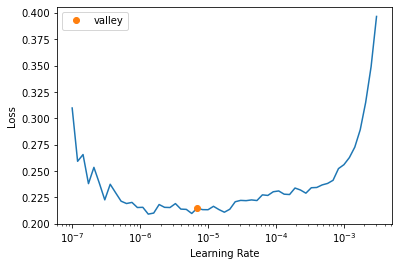

In [33]:
learn.lr_find()

We can see that this plot is different than before as we are finding the best minima to land on an already trained model. Let's choose an LR somewhere in the middle before the loss explodes again! 

Something like 1e-5 as the `lr_max` would do good here in order to avoid the spike in loss that follows. Let's train the model further. 

In [34]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.237454,0.161343,0.957239,00:33
1,0.210835,0.139617,0.964569,00:33
2,0.178369,0.132423,0.963348,00:33
3,0.164499,0.126942,0.967013,00:33
4,0.134416,0.125237,0.966402,00:33
5,0.139693,0.124959,0.965180,00:33


In addition to these steps, the 1 cycle policy also implements the `cyclical momentum` trick as mentioned by Leslie Smith in his [paper](https://arxiv.org/pdf/1803.09820.pdf). 

> ***Side Note:*** `Momentum` is a technique where the optimizer takes a step not only in the direction of the gradients, but also continues in the direction of previous steps. This allows the model training to move smoothly considering our previous steps taken and not being solely determined by the gradient of a single batch.

Leslie Smith suggests that momentum and learning rate should be inversely proportional in the training process. I.e. when we are at high learning rate, we use less momentum, and we use more again in the annealing phase. By doing so, the learning rate is given higher priority in the tail end of warm up to go in new directions to find the flatter area and then slowly move to the best minima while giving momentum greater priority. 

In practice Fastai shifts between a max and minimum momentum of 0.85 to 0.95 as mentioned by Leslie in the two phases of training. 

We can view the learning rates and momentum plots during training as follows:

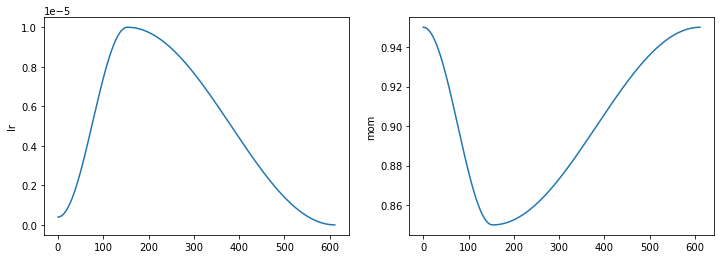

In [35]:
learn.recorder.plot_sched()

We can clearly see that the plots between learning rate and momentum are inversely proportional as explained above.

Let's view the `plot_loss` graph to see how well the training is going on:

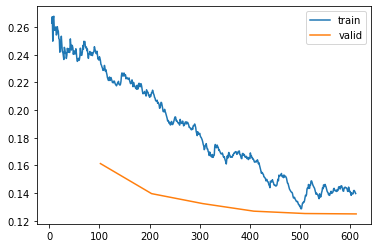

In [36]:
learn.recorder.plot_loss()

We can see that the training loss and validation loss is stil decreasing and we get an accuracy of about 97%. 

> To learn more about the 1cycle training approach refer to Sylvain's [post](https://sgugger.github.io/the-1cycle-policy.html#the-1cycle-policy) on it or chapter 13 of the [Fastbook](https://github.com/fastai/fastbook).

---

## Discriminative learning rates

In my previous post I explain how every CNN has a "feature extraction" section and "classifier" section and when we use transfer learning we just save the feature extracted part as that's the part we really care about and would like to use for our specific application.

Thus the main idea behind using `discriminative learning rates` is that, when using pretrained models the features learnt by the model in the early layers are very very useful and we wouldn't want to change it too much. We would like to use the best learning rate for the deeper layers where there can be a divergence in the features learnt based on our specific classification task. Therefore it doesn't make sense to use a single learning rate all over the architecture. Thus we use a smaller learning rate for the earliest layers and gradually increase the learning rate as we step through the layers. 

Fastai lets you pass a Python *slice* object anywhere that a learning rate is expected. The first value past will be the learning rate in the earliest layer of the neural network, and the second value will be the learning rate in the final layer. The layers in between will have learning rates that are multiplicatively equidistant throughout that range. Let's use this approach to replicate the previous training, but this time we'll only set the *lowest* layer of our net to a learning rate of `1e-6`; the other layers will scale up to `1e-4`. Let's train for a while and see what happens.

In [37]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.975725,0.379355,0.898595,00:28
1,0.632504,0.197101,0.940745,00:28
2,0.308854,0.158545,0.960293,00:28


epoch,train_loss,valid_loss,accuracy,time
0,0.228445,0.151607,0.960293,00:33
1,0.215621,0.141218,0.962737,00:33
2,0.175449,0.132701,0.966402,00:33
3,0.157977,0.119855,0.968235,00:33
4,0.133629,0.106258,0.969456,00:33
5,0.121026,0.102839,0.970678,00:33
6,0.110257,0.099454,0.970678,00:33
7,0.090136,0.095722,0.971289,00:33
8,0.088847,0.092969,0.972511,00:33
9,0.079795,0.093075,0.969456,00:33


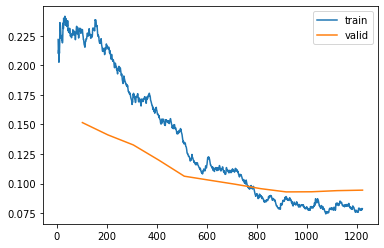

In [38]:
learn.recorder.plot_loss()

> ***Inference as taken from Fastbook***:
"As you can see, the training loss keeps getting better and better. But notice that eventually the validation loss improvement slows, and sometimes even gets worse! This is the point at which the model is starting to over fit. In particular, the model is becoming overconfident of its predictions. But this does ***not*** mean that it is getting less accurate, necessarily. Have a look at the table of training results per epoch, and you will often see that the accuracy continues improving, even as the validation loss gets worse. In the end what matters is your accuracy, or more generally your chosen metrics, not the loss. The loss is just the function we've given the computer to help us to optimise."

---

## Number of epochs of training

Let's try training the model a little more and see what happens:

In [39]:
learn.fit_one_cycle(3, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.079713,0.092469,0.971289,00:33
1,0.067934,0.087500,0.974954,00:33
2,0.062209,0.086632,0.973122,00:33


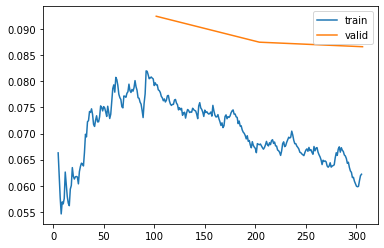

In [40]:
learn.recorder.plot_loss()

We can see that the ***number of epochs*** of training is quite important as shown in this case. 

Training a lot will mean we overfit as shown by the large divergence between training loss and validation loss as shown above. Here training loss is reducing but accuracy on validation set as well as validation loss has increased drastically again. This indicates that the model isn't generalizing well to the 102 classes of flowers but instead trying to memorize the images of the specific flowers per class in our training set.  

> ***Note:*** The most important value we care about is our metric i.e. our accuracy in this case! The validation loss is a created metric in order for the learning process to take place, so even if the validation loss reduced but our main metric i.e. accuracy increases then our training is still on the right track!

So in order to find the ideal number of epochs to train Fastai suggests to employ the `fit_one_cycle` method, unfreeze and train a set number of epochs till you find that your model metric is still reducing and the training is going on well. The point where you see that metric is going wack and not training properly anymore is where you have gone too far and need to start training again till an epoch or two before! 

---

## Deeper architectures

Till now we have used a `resnet34` architecture which indicates that it has 34 layers.

>"In general, a bigger model has the ability to better capture the real underlying relationships in your data, and also to capture and memorise the specific details of your individual images." - Fastbook Chapter 5

Let's train a deeper pretrained model in the form of resnet50 which has 50 layers as compared to the 34 layers used till now.

In [80]:
from fastai.callback.fp16 import *

learn = vision_learner(dls, resnet50, metrics=accuracy).to_fp16()
learn.fine_tune(6, freeze_epochs=3)


epoch,train_loss,valid_loss,accuracy,time
0,2.852885,0.794613,0.796579,00:24
1,0.950806,0.297811,0.919976,00:24
2,0.450831,0.246811,0.934026,00:24


epoch,train_loss,valid_loss,accuracy,time
0,0.165750,0.168596,0.956017,00:28
1,0.140767,0.190361,0.941967,00:29
2,0.109944,0.135021,0.963958,00:28
3,0.047105,0.102164,0.966402,00:28
4,0.022884,0.077443,0.977398,00:28
5,0.011834,0.074128,0.979841,00:28


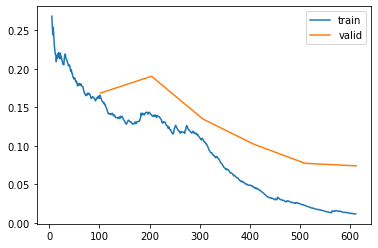

In [81]:
learn.recorder.plot_loss()

In [82]:
learn.save('flowers-resnet50')

Path('models/flowers-resnet50.pth')

In [88]:
learn.load('flowers-resnet50')
learn.validate()

(#2) [0.07412809878587723,0.9798411726951599]

We can see that a deep resnet 50 architecture surely helps in bringing up the accuracy of the model to just over 98%.

> ***Note:*** This isn't always the case and using deeper architectures could lead to worser models.

> "Bigger models aren't necessarily better models for your particular case! Make sure you try small models before you start scaling up." - Fastbook Chapter 5

In [91]:
#hide
learn = vision_learner(dls, resnet50, metrics=accuracy).to_fp16()
learn.load('flowers-resnet50')

Let's try to fine-tune this deeper resnet50 model by using the strategies we used earlier on:

SuggestedLRs(valley=4.365158383734524e-05)

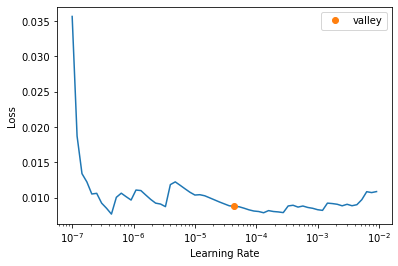

In [92]:
learn.lr_find()

In [93]:
learn.unfreeze()
learn.fit_one_cycle(3, lr_max=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.011237,0.080620,0.976787,00:29
1,0.006528,0.069570,0.981063,00:28
2,0.004849,0.069127,0.981063,00:28


After a bit more of training the model reaches the 98% mark all while the training loss and validation loss is still reducing. 

Let's save this as the final model for further use and set it as our current benchmark model on the flowers-102 dataset. 

In [94]:
learn.save('flowers-resnet50-best')

Path('models/flowers-resnet50-best.pth')

In [95]:
learn.validate()

(#2) [0.06912674754858017,0.9810629487037659]

---

## Conclusion

In this post, we have successfully seen how to take a baseline model and improve upon it considerably.

We started with a baseline model at 96% accuracy and after employing some Fastai suggested methods we were able to build a model with an accuracy of 98%. All this is acheived by using the inbuilt convenience functions used in Fastai by using transfer learning. 

There are definitely a load other tricks that can be done to this model to make it more robust and generalize better like employing tricks like progressive resizing, test time augmentation, mixup, adding regularization like dropout and using weight decay. 

I'm currently working on getting a better grasp of all these techniques and will be posting more about them in the upcoming blogs!

---

## References

1. [Fastai Documentation](http://docs.fast.ai)

2. [Fastbook](https://github.com/fastai/fastbook) i.e Deep Learning for Coders with Fastai and Pytorch: AI Applications Without a PhD by Jeremy Howard and Sylvain Gugger
3. [How do you find a good learning rate](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html#how-do-you-find-a-good-learning-rate) post by Sylvain Gugger
4. [1 cycle policy](https://sgugger.github.io/the-1cycle-policy.html#the-1cycle-policy) post by Sylvain Gugger
5. [Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120) paper by Leslie Smith.

6. [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186) paper by Leslie Smith.

---

Happy learning! :)

---